# Self-Driving Car Engineer Nanodegree


## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

## 1. Load Car and NotCar dataset

data size: 8792 8968


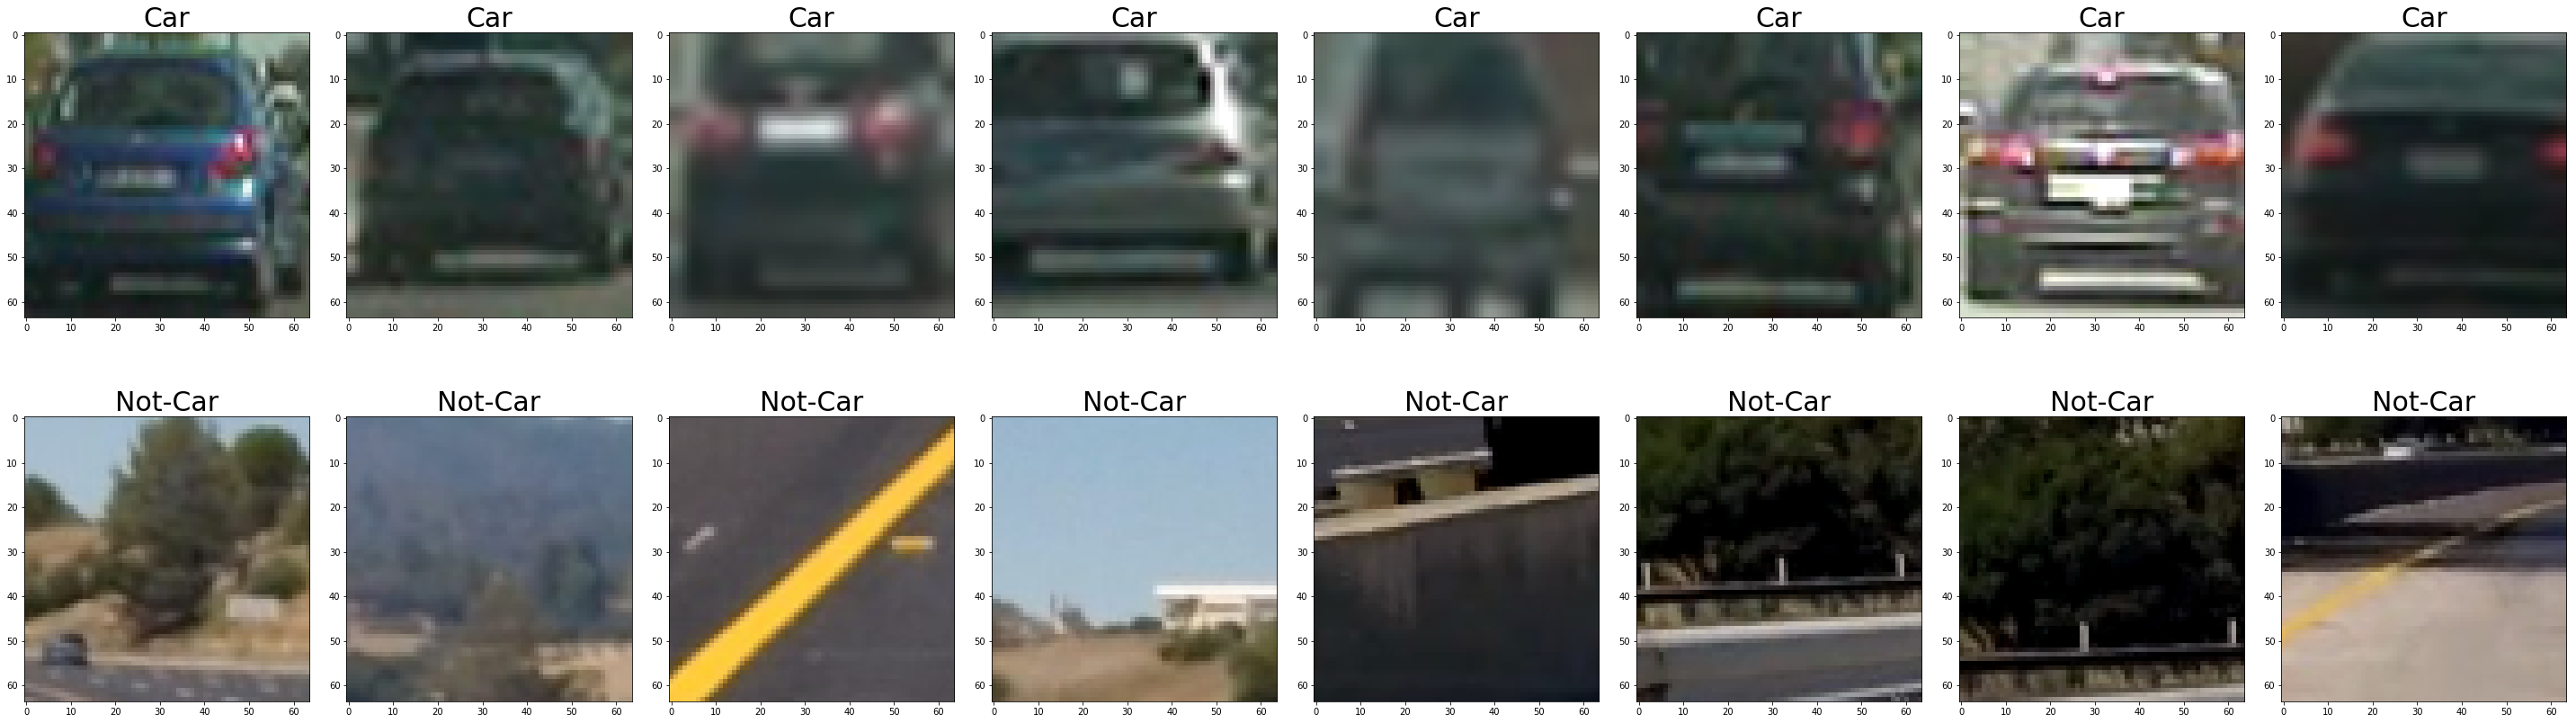

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from lesson_functions import *

import numpy as np
import pickle
%matplotlib inline

#Car and Non-car Dataset
car_fnames = glob.glob('dataset/vehicles/*/*.png')
notcar_fnames = glob.glob('dataset/non-vehicles/*/*.png')
#sample_size = 500
#car_fnames  = car_fnames [0:sample_size]
#notcar_fnames  = notcar_fnames [0:sample_size]
#######################################################################

def test_dataset():    
    print("data size:",len(car_fnames), len(notcar_fnames))

    mx=8
    fig, axes = plt.subplots(2, mx, figsize=(40, 12))
    fig.tight_layout()
    for im in range(0,mx):
        img = mpimg.imread(car_fnames[im])
        axes[0,im].set_title("Car", fontsize=30)
        axes[0,im].imshow(img)
        img = mpimg.imread(notcar_fnames[im])
        axes[1,im].set_title("Not-Car", fontsize=30)
        axes[1,im].imshow(img)

#----------------------------------------------------------
test_dataset()       


## 2. Histogram of Oriented Gradients (HOG) Testing

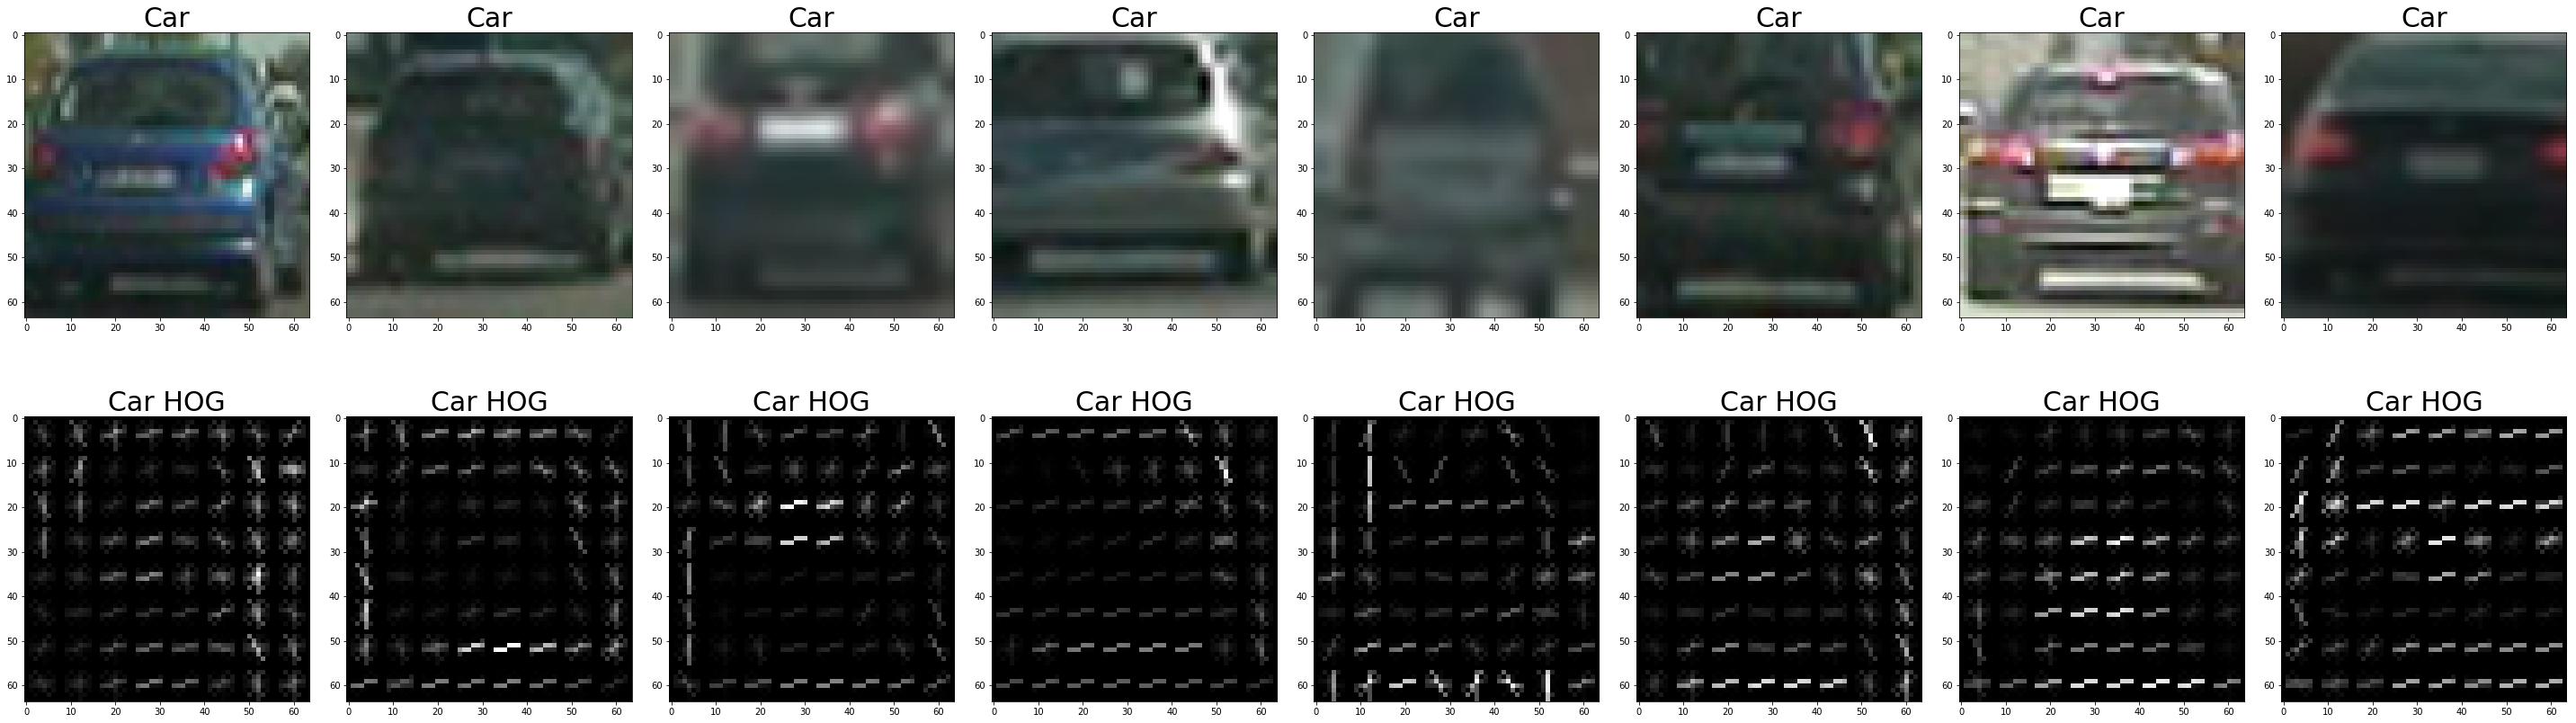

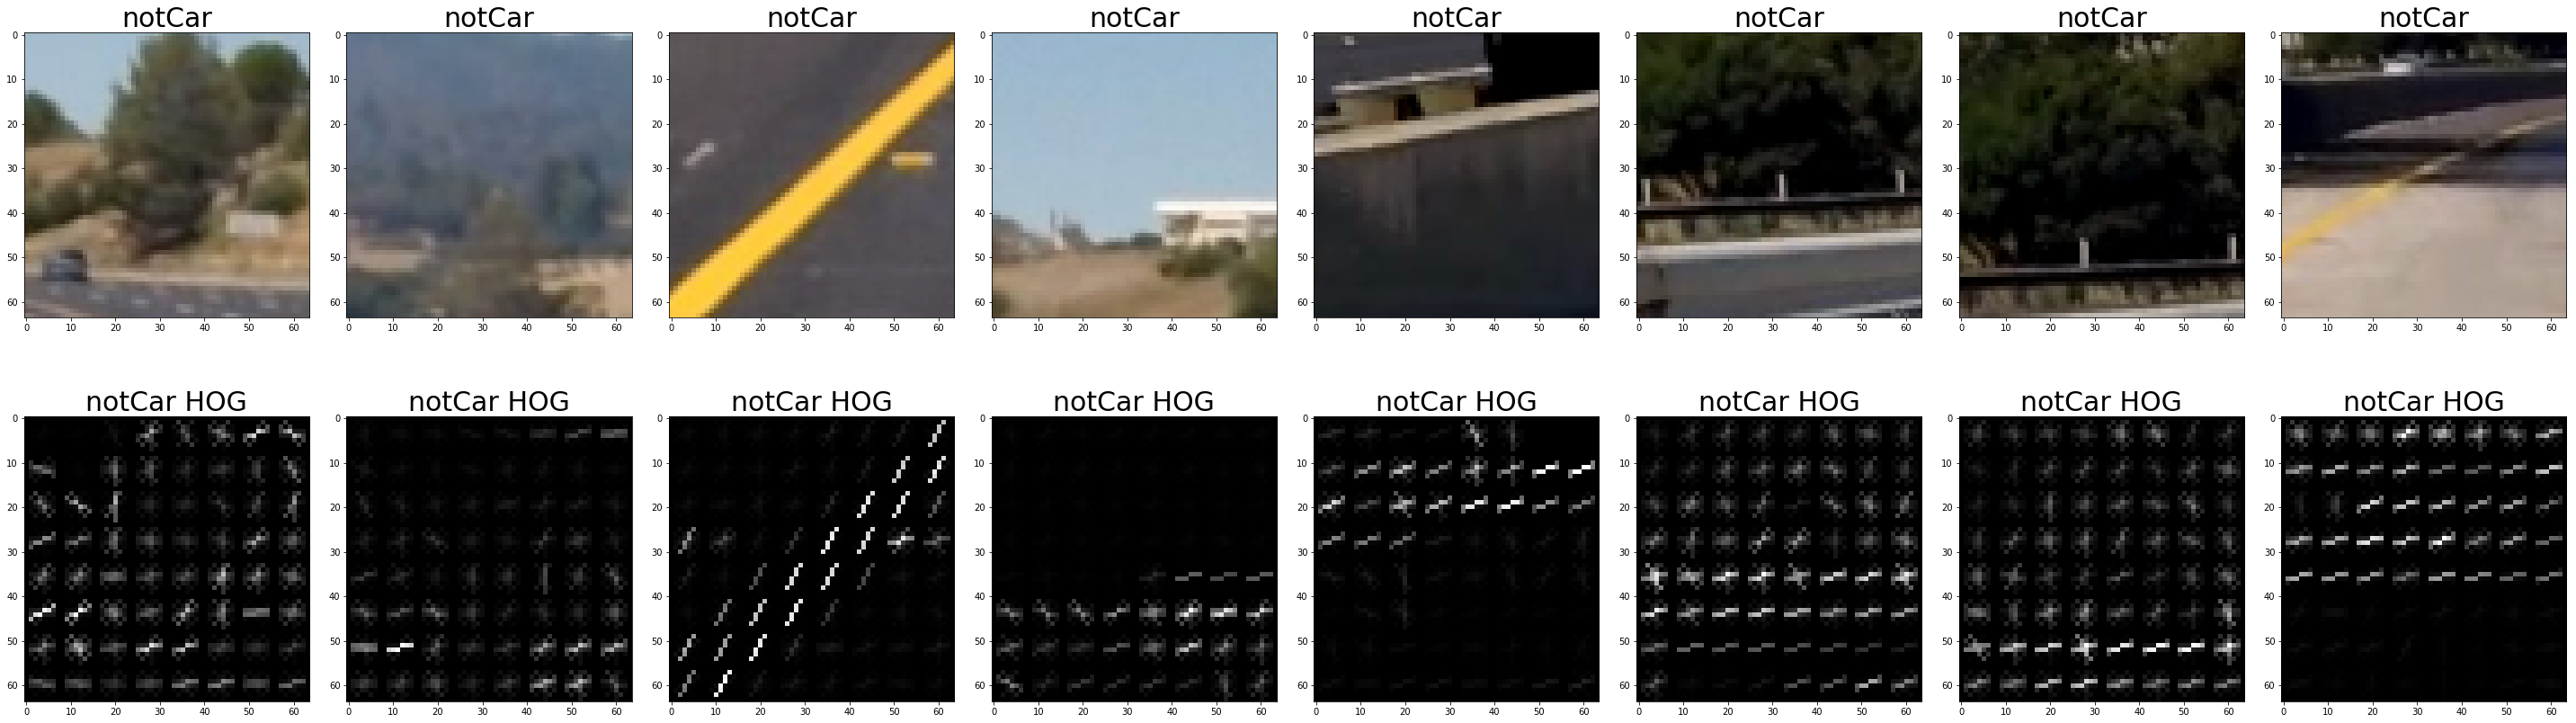

In [2]:
def test_hog_features(fnames,name="Car",nameHOG="Car HOG"):
    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2    
    
    mx=8
    fig, axes = plt.subplots(2, mx, figsize=(40, 12))
    fig.tight_layout()

    for im in range(0,mx):
        img = mpimg.imread(fnames[im])
        axes[0,im].set_title(name, fontsize=30)
        axes[0,im].imshow(img)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
        axes[1,im].set_title(nameHOG, fontsize=30)
        axes[1,im].imshow(hog_image, cmap='gray')
#-----------------------------------------------------------------------------
test_hog_features(car_fnames,name="Car",nameHOG="Car HOG")
test_hog_features(notcar_fnames,name="notCar",nameHOG="notCar HOG")

## 3. Determine HOG Parameters and Traning Classifier

In [3]:
### Default of HOG Parameters.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
svc = None
X_scaler = None
k_threshold = 4

def initParameters(m_color_space, m_orient, m_pix_per_cell, m_cell_per_block, 
                  m_hog_channel, m_spatial_size, m_hist_bins, 
                  m_spatial_feat, m_hist_feat, m_hog_feat):
    
    global color_space, orient, pix_per_cell, cell_per_block 
    global hog_channel, spatial_size, hist_bins 
    global spatial_feat, hist_feat,hog_feat

    color_space    = m_color_space
    orient         = m_orient
    pix_per_cell   = m_pix_per_cell
    cell_per_block = m_cell_per_block
    hog_channel    = m_hog_channel
    spatial_size   = m_spatial_size
    hist_bins      = m_hist_bins
    spatial_feat   = m_spatial_feat
    hist_feat      = m_hist_feat
    hog_feat       = m_hog_feat

    #print(color_space, orient, pix_per_cell, cell_per_block, 
    #      hog_channel, spatial_size, hist_bins, spatial_feat, hist_feat, hog_feat)

In [4]:
def train_Classifier(car_imgs, notcar_imgs, fparam='./model-params/model-params.pk'):
    
    # Feature Extraction    
    t=time.time()
    car_features = extract_features(car_imgs, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcar_imgs, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

    # Feature Normalization
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Train-test Split
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    
    # Use a linear SVC for Traning
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

    params={
        'svc': svc,
        'X_scaler': X_scaler,
        'color_space': color_space,
        'orient': orient,
        'pix_per_cell': pix_per_cell,
        'cell_per_block': cell_per_block,
        'hog_channel': hog_channel,
        'spatial_size' : spatial_size,
        'hist_bins': hist_bins
         }

    with open(fparam, 'wb') as pFile:
        pickle.dump(params, pFile)       
#-----------------------------------------------------------------------

def genParameters():
    ii=0
    mspaces  = ['RGB', 'HSV','HLS', 'YCrCb']
    morients = [5 , 9 , 13]
    mppcels  = [6, 8, 12]
    morient = 9
    mppcel  = 8
    for mspace in mspaces: 
        fparam = './model-params/A' + str(ii) + '_' + mspace + '_' + str(morient) + '_' + str(mppcel) + '.pk'
        print('------------------------------------------------------------------')
        print('Traning ...', fparam)
        initParameters(mspace, morient, mppcel, 2, "ALL", (32,32), 32, True, True, True)
        train_Classifier(car_fnames,notcar_fnames, fparam)
        ii = ii + 1

    mspace   = 'YCrCb'
    mppcel   = 8
    for morient in morients:
        fparam = './model-params/A' + str(ii) + '_' + mspace + '_' + str(morient) + '_' + str(mppcel) + '.pk'
        print('------------------------------------------------------------------')
        print('Traning ...', fparam)
        initParameters(mspace, morient, mppcel, 2, "ALL", (32,32), 32, True, True, True)
        train_Classifier(car_fnames,notcar_fnames, fparam)
        ii = ii + 1

    mspace   = 'YCrCb'
    morient  = 9
    for mppcel in mppcels:
        fparam = './model-params/A' + str(ii) + '_' + mspace + '_' + str(morient) + '_' + str(mppcel) + '.pk'
        print('------------------------------------------------------------------')
        print('Traning ...', fparam)
        initParameters(mspace, morient, mppcel, 2, "ALL", (32,32), 32, True, True, True)
        train_Classifier(car_fnames,notcar_fnames, fparam) 
        ii = ii + 1

#------------------------------------------
genParameters()

------------------------------------------------------------------
Traning ... A0_RGB_9_8.pk
100.74 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
31.79 Seconds to train SVC...
Test Accuracy of SVC =  0.9665
My SVC predicts:  [ 1.  1.  0.  1.  1.  1.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  1.  1.  1.  0.  0.  1.  0.]
0.00162 Seconds to predict 10 labels with SVC
------------------------------------------------------------------
Traning ... A1_HSV_9_8.pk
93.45 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
24.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9854
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  0.  0.  0.  0.]
0.0016 Seconds to predict 10 labels with SVC
------------------------------------------------------------------
Traning ... A2_HLS_9_8.p

## 4. Sliding Window Search

In [5]:
def readParameters(fparam):
    with open(fparam, 'rb') as pfile:
        params = pickle.load(pfile)
    for key in params:
        exec("global " + key + ";" + key + "= params['" + str(key) + "']")
    del params
    print("Color_space :", color_space)
    print("Orient      :", orient)
    print("Pix_per_cell:",pix_per_cell)

#------------------------------------------------------------------------------
fparam = './model-params/A5_YCrCb_9_8.pk'
readParameters(fparam)    

Color_space : YCrCb
Orient      : 9
Pix_per_cell: 8


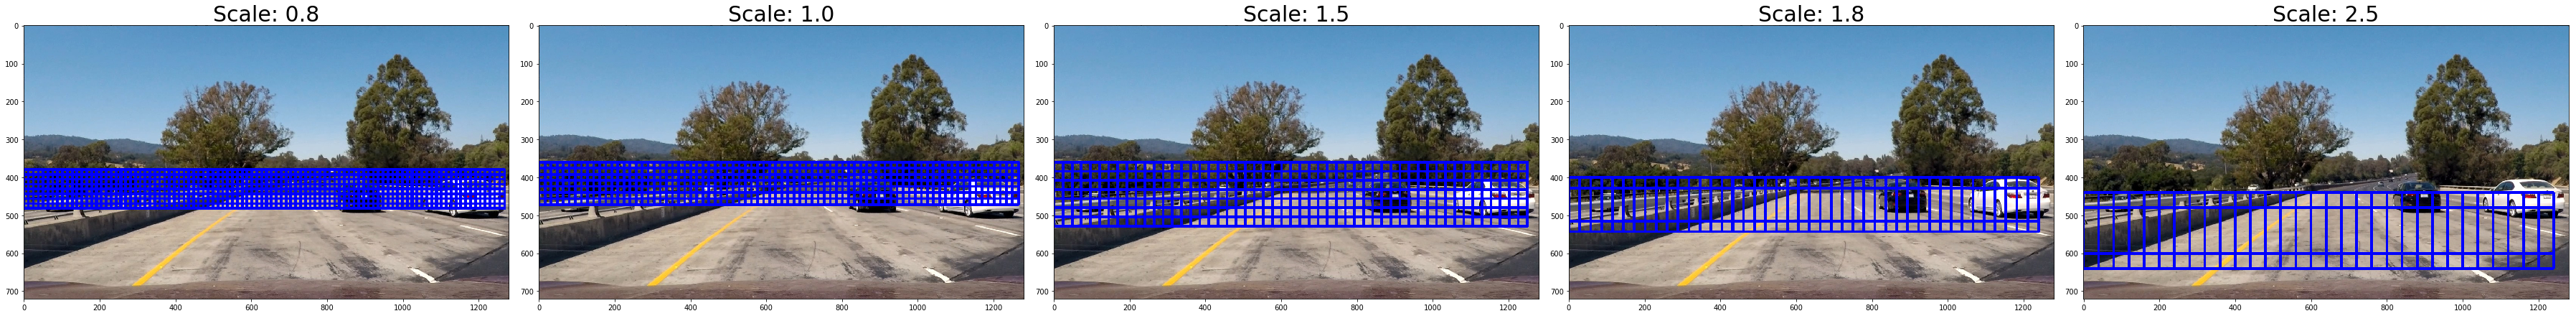

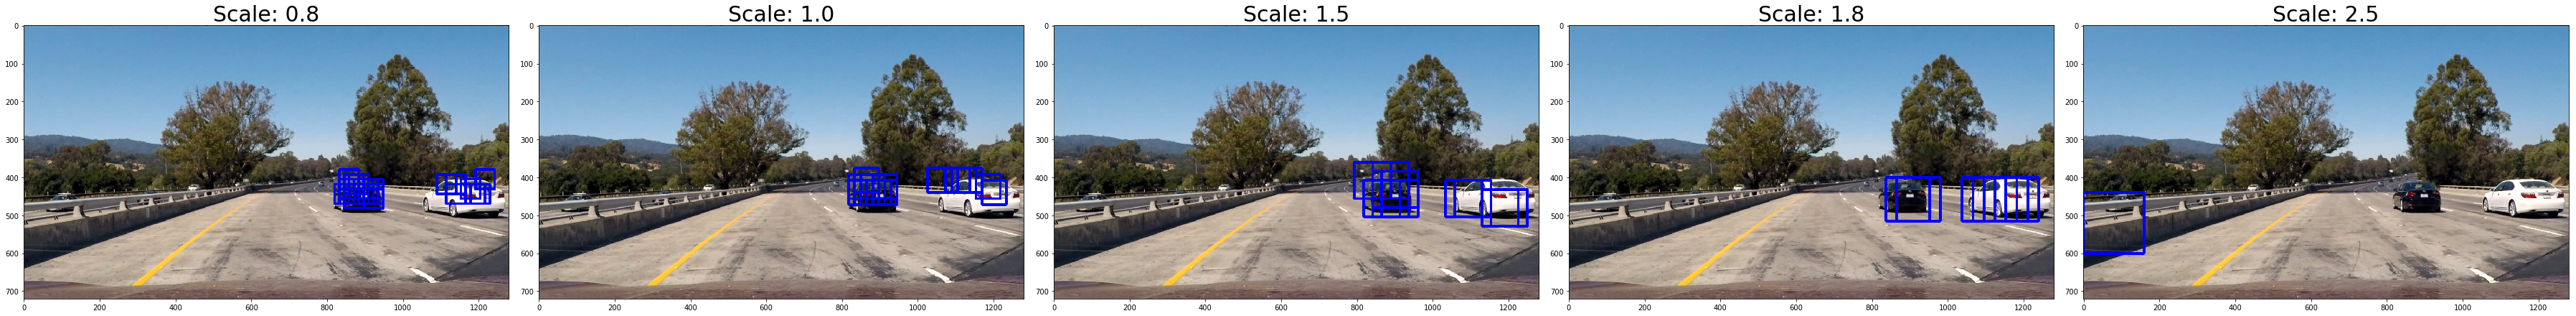

In [6]:
def test_find_cars(fname, bCar):
    #bCar:True  -- detect the Car position
    #bCar:False -- list of sliding windows
    
    img = mpimg.imread(fname)

    xstart_stop = (0, img.shape[1])    
    #xstart_stop = (640+32, img.shape[1]) 
    #ystart_stopes=((360, 500), (360, 560), (400, 600), (440, 700))
    #ystart_stopes=((360, 500), (360, 500), (360, 560), (400, 600), (440, 700))
    ystart_stopes=((380, 500), (360, 500), (360, 560), (400, 600), (440, 700))
    scales=(0.8, 1.0, 1.5, 1.8, 2.5)    
    
    ns = 5
    fig, axes = plt.subplots(1, ns, figsize=(10*ns,6))
    fig.tight_layout()
    
    for im in range(0, ns):
        ystart_stop = ystart_stopes[im]
        scale  = scales[im]
        hot_windows=find_cars(img, xstart_stop, ystart_stop, scale, svc, X_scaler, 
                            color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins, bCar=bCar)
        draw_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)
        tname = "Scale: " + str(scale) 
        axes[im].set_title(tname, fontsize=30)
        axes[im].imshow(draw_img)          

#----------------------------------------------------------
test_find_cars('test_images/test1.jpg', False)
test_find_cars('test_images/test1.jpg', True)

## 5. Search for vehicles in test images

In [7]:
############################################################################################
def find_cars_scales(image):  
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    # it is done in find_cars() !!!!!!!!!!!
    #image = image.astype(np.float32)/255
    
    #x_start_stop = [None, None] # Min and max in x to search in slide_window()
    #xstart_stop = (0, image.shape[1]) 
    #xstart_stop = (np.int(image.shape[1]/2), image.shape[1]) 
    #xstart_stop = (640+32, image.shape[1]) 
    xstart_stop = (672, image.shape[1]) 
    
    #y_start_stop = [None, None] # Min and max in y to search in slide_window()
    #x_start_stop=(0, image.shape[1])
    #y_start_stop=(250, image.shape[0])
    #y_start_stop=(300, image.shape[0])
    
    #y_start_stop=((400, 464),(400, 496),(400, 528),(400, 624))
    #scales=(1.0,1.5,2.0,3.5)    
    #y_start_stop=((360, 560), (400, 600), (440, 700))
    #scales=(1.5, 1.8, 2.5)
    
    #ystart_stopes=((360, 500), (360, 560), (400, 600), (440, 700))
    #scales=(1.0, 1.5, 1.8, 2.5)
    
    #ystart_stopes=((360, 500), (360, 500), (360, 560), (400, 600), (440, 700))
    ystart_stopes=((380,500), (360, 500), (360, 560), (400, 600), (440, 700))
    scales=(0.8, 1.0, 1.5, 1.8, 2.5)
    
    hot_windows = []        
    for ii in range(0, len(scales)):
        #xy_window = (int(64*scales[ii]),int(64*scales[ii]))
        #windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop[ii], 
        #                xy_window=xy_window, xy_overlap=(0.5, 0.5))

        #hot_windows.append(search_windows(image, windows, svc, X_scaler, color_space=color_space, 
        #                    spatial_size=spatial_size, hist_bins=hist_bins, 
        #                    orient=orient, pix_per_cell=pix_per_cell, 
        #                    cell_per_block=cell_per_block, 
        #                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
        #                    hist_feat=hist_feat, hog_feat=hog_feat))                       

        ystart_stop = ystart_stopes[ii]
        scale  = scales[ii]
        hot_windows.append(find_cars(image, xstart_stop, ystart_stop, scale, svc, X_scaler, 
                            color_space, orient, pix_per_cell, cell_per_block, 
                            hog_channel, spatial_size, hist_bins,True))
        
    hot_windows = [item for sublist in hot_windows for item in sublist] 

    return hot_windows
############################################################################################

from scipy.ndimage.measurements import label    
def test_detectedCar(images):
    mx=4
    my=len(images)
    fig, axes = plt.subplots(my, mx, figsize=(10*mx,6*my))
    fig.tight_layout()
    im=0   
    for im in range(my):
        fname = images[im]
        img = mpimg.imread(fname)
        hot_windows = find_cars_scales(img)
        draw_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)
        axes[im,0].set_title(fname, fontsize=30)
        axes[im,0].imshow(draw_img)  
                
        heat_img = np.zeros_like(img[:,:,0])
        heat_img = add_heat(heat_img, hot_windows)
        heat_img = apply_threshold(heat_img, k_threshold)
        axes[im,1].set_title("Heat Map w/t Threshold", fontsize=30)
        axes[im,1].imshow(heat_img, cmap='hot') 
        
        labels = label(heat_img)
        axes[im,2].set_title("Label", fontsize=30)
        axes[im,2].imshow(labels[0], cmap='gray') 
        
        draw_img = draw_labeled_bboxes(np.copy(img), labels)        
        axes[im,3].set_title(str(labels[1]) + " cars found", fontsize=30)
        axes[im,3].imshow(draw_img)       

#----------------------------------------------------------------------------------------

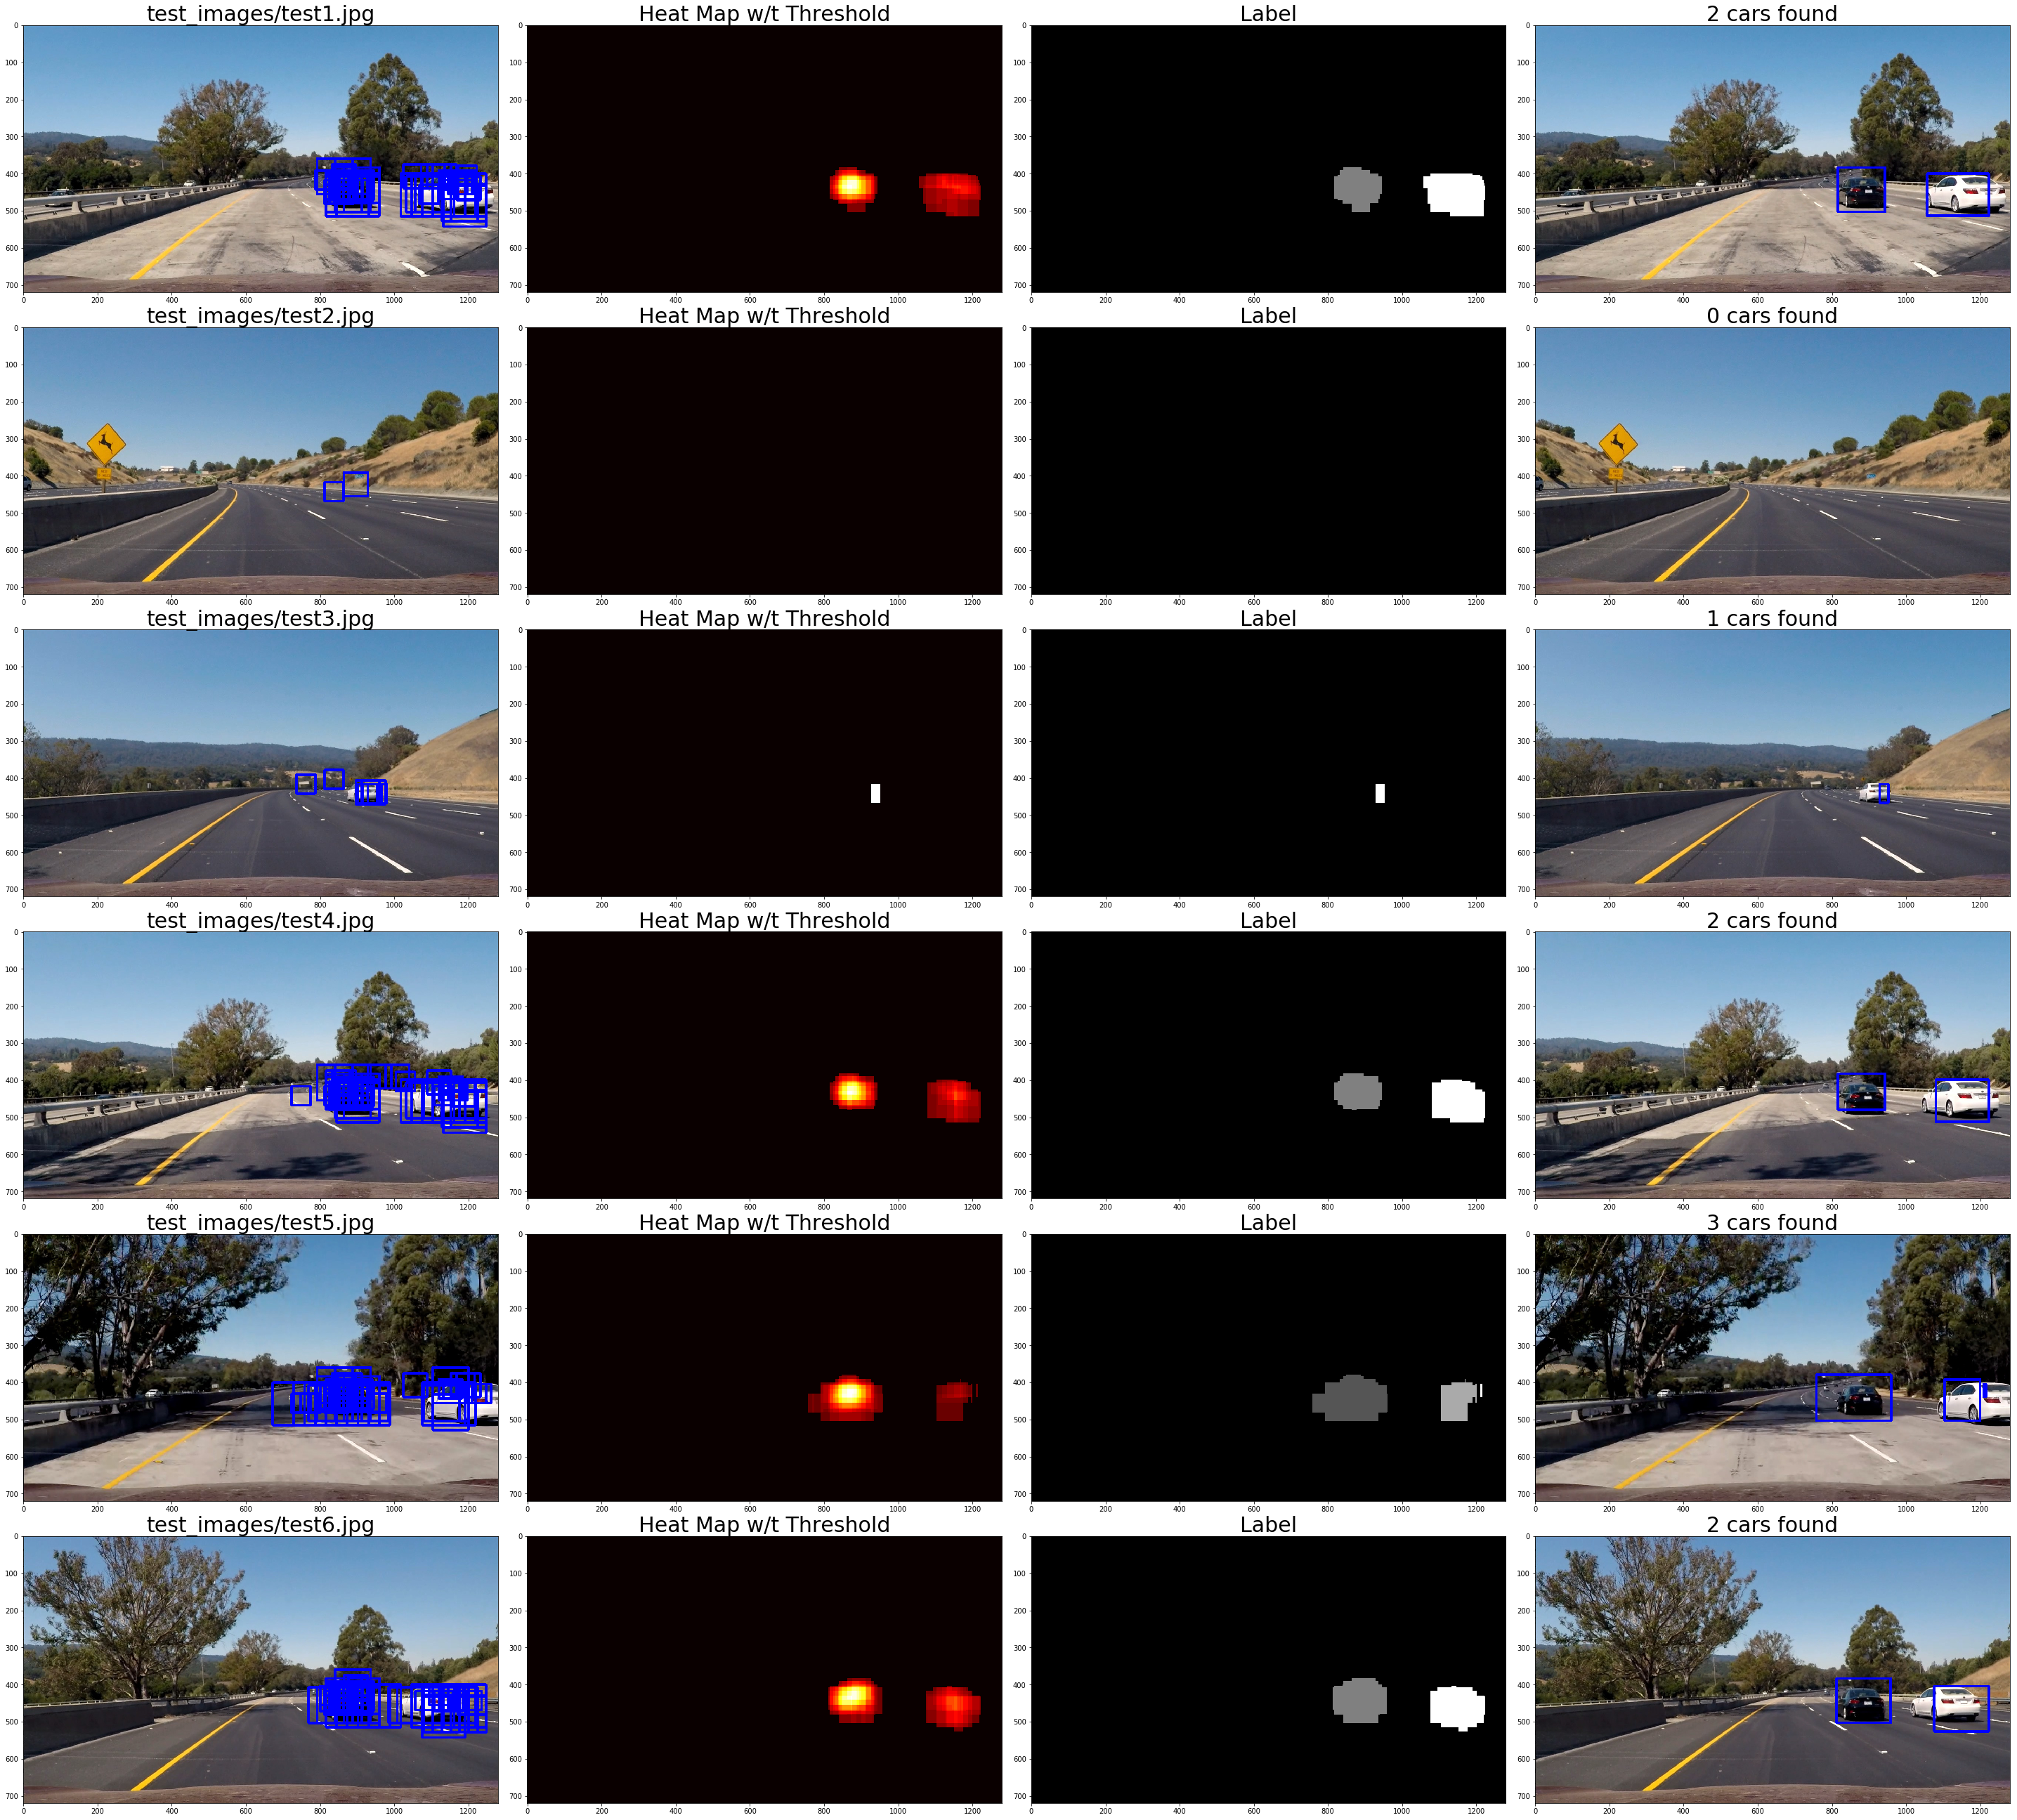

In [8]:
k_threshold = 4
#flists=('test_images/test5.jpg','test_images/test6.jpg')
flists=sorted(glob.glob('test_images/*.jpg'))
test_detectedCar(flists)

## 6. Video Results

### (a) Test Video

[MoviePy] >>>> Building video test_video_output_10sumX4.mp4
[MoviePy] Writing video test_video_output_10sumX4.mp4


 97%|█████████▋| 38/39 [00:22<00:00,  1.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output_10sumX4.mp4 

CPU times: user 38.1 s, sys: 64 ms, total: 38.2 s
Wall time: 23.5 s


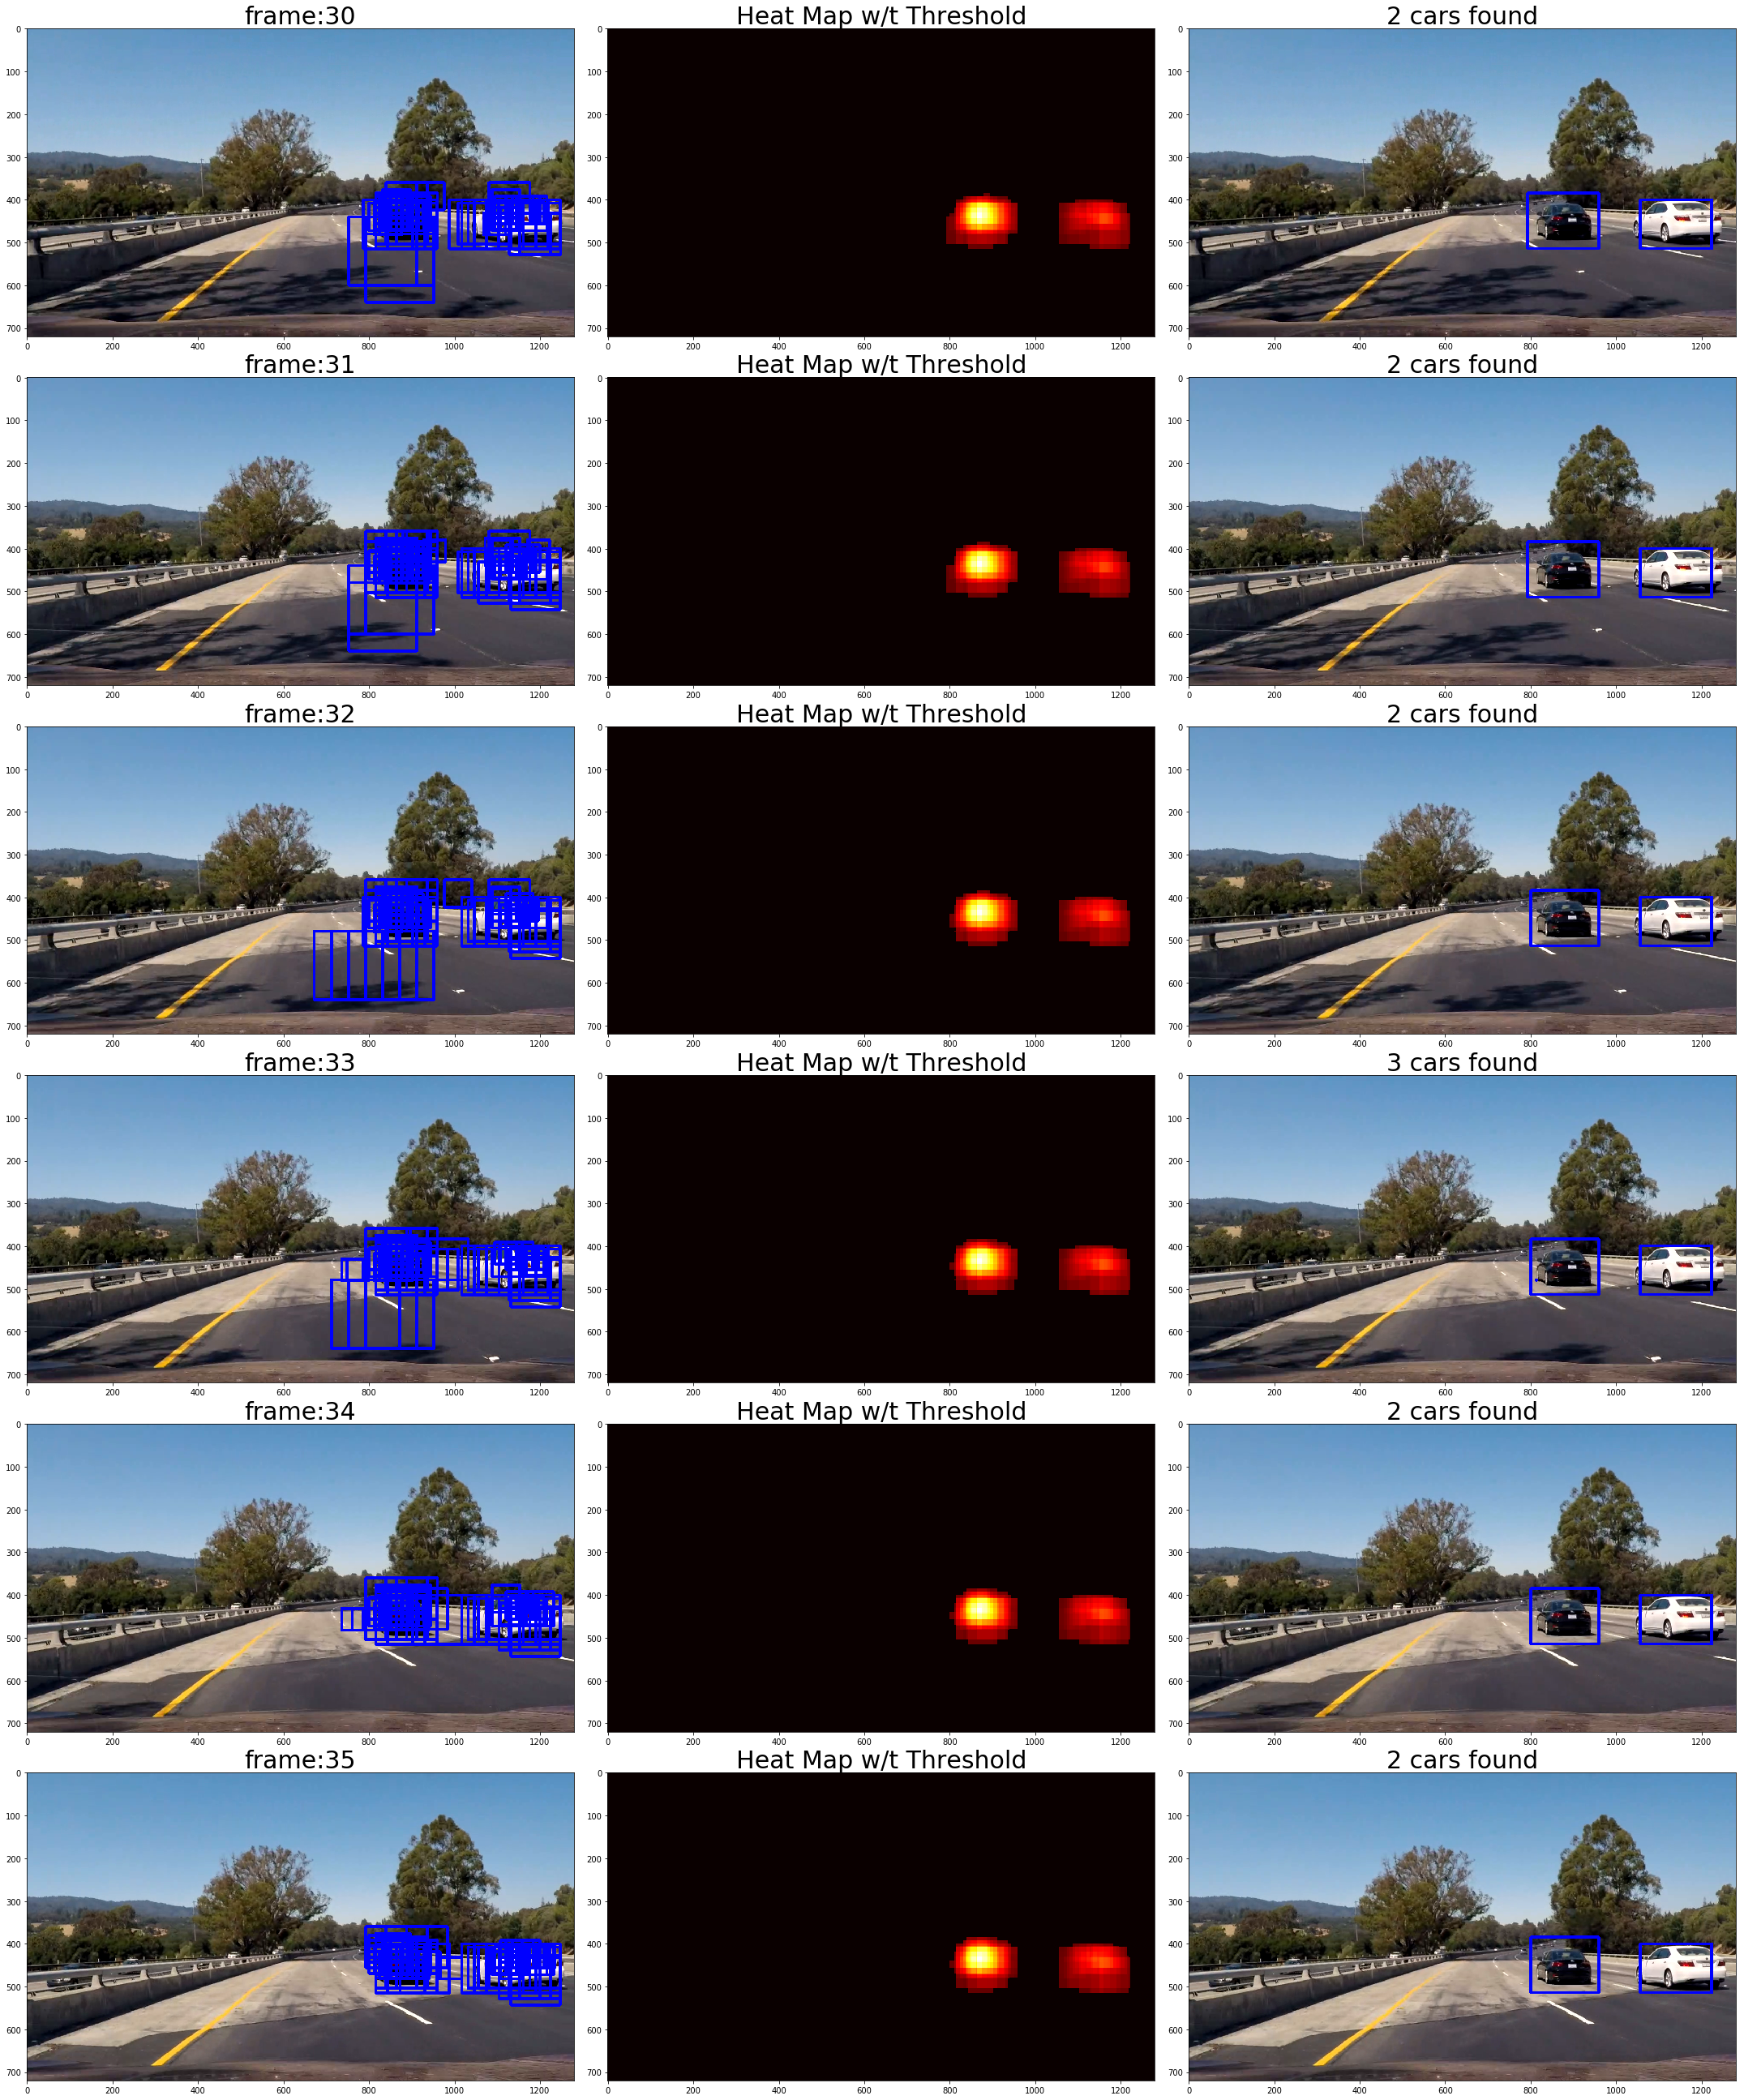

In [56]:
from collections import deque

#maxlen=1
#k_threshold = 4

maxlen=10
k_threshold = 4

heat_imgs = deque(maxlen=maxlen) 

video_input  = 'test_video.mp4'
#video_output = 'test_video_output.mp4'
video_output = 'test_video_output_' + str(maxlen) + 'sumX'+ str(k_threshold) +'.mp4'

mis=30
men=36
my=men-mis
mx=3

fig, axes = plt.subplots(my, mx, figsize=(10*mx,6*my))
fig.tight_layout()
ic=0 

def process_image_plot(img):
    global ic
    hot_windows = find_cars_scales(img)
    heat_img = np.zeros_like(img[:,:,0])
    heat_img = add_heat(heat_img, hot_windows)
    heat_imgs.append(heat_img)
    
    #heat_img = np.mean(np.array(heat_imgs), axis=0)
    heat_img = np.sum(np.array(heat_imgs), axis=0)
    heat_img = apply_threshold(heat_img, k_threshold*min(maxlen,ic+1))
       
    labels = label(heat_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    if (mis <= ic) and (ic < men):
        im=ic-mis
        fname="frame:" + str(ic)
        box_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)
        axes[im,0].set_title(fname, fontsize=30)
        axes[im,0].imshow(box_img) 
        axes[im,1].set_title("Heat Map w/t Threshold", fontsize=30)
        axes[im,1].imshow(heat_img, cmap='hot') 
        #axes[im,2].set_title("Label", fontsize=30)
        #axes[im,2].imshow(labels[0], cmap='gray') 
        axes[im,2].set_title(str(labels[1]) + " cars found", fontsize=30)
        axes[im,2].imshow(draw_img)   
        
    ic = ic+ 1
    
    return draw_img
   
#####################################################################################

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clip2 = VideoFileClip(video_input) #.subclip(30,45)
img_clip = clip2.fl_image(process_image_plot)
%time img_clip.write_videofile(video_output, audio=False)

### (b) Project Video

In [58]:
from collections import deque

#maxlen=1
#k_threshold = 4

maxlen=10
k_threshold = 6 
heat_imgs = deque(maxlen=maxlen) 

def process_image(img):
    hot_windows = find_cars_scales(img)
    heat_img = np.zeros_like(img[:,:,0])
    heat_img = add_heat(heat_img, hot_windows)
    heat_imgs.append(heat_img)
    
    #heat_img = np.sum(np.array(heat_imgs), axis=0)
    #heat_img = apply_threshold(heat_img, k_threshold*maxlen)

    #heat_img = np.mean(np.array(heat_imgs), axis=0)
    heat_img = np.sum(np.array(heat_imgs), axis=0)
    heat_img = apply_threshold(heat_img, k_threshold*min(maxlen,ic+1))
   
    
    labels = label(heat_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    #draw_img = draw_boxes(np.copy(img), hot_windows, color=(0, 0, 255), thick=6)
    #plt.imshow(draw_img)
    #plt.imshow(heat_img, cmap='hot') 
    return draw_img

#####################################################################################

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#video_input  = 'test_video.mp4'
#video_output = 'test_video_output.mp4'

video_input  = 'project_video.mp4'
#video_output = 'project_video_output.mp4'
video_output = 'project_video_output_' + str(maxlen) + 'sumX'+ str(k_threshold) +'.mp4'

clip2 = VideoFileClip(video_input) #.subclip(30,45)
img_clip = clip2.fl_image(process_image)
%time img_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output_10sumX6.mp4
[MoviePy] Writing video project_video_output_10sumX6.mp4


100%|█████████▉| 1260/1261 [12:41<00:00,  1.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_10sumX6.mp4 

CPU times: user 21min 35s, sys: 2.21 s, total: 21min 37s
Wall time: 12min 42s
